## Goal: Price Prediction of Airbnb rentals in Sydney based on Features 

In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

In [261]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [324]:
train = pd.read_csv('train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20408 entries, 0 to 20407
Data columns (total 60 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   name                                          20408 non-null  object 
 1   description                                   19751 non-null  object 
 2   neighborhood_overview                         12536 non-null  object 
 3   host_name                                     20408 non-null  object 
 4   host_since                                    20408 non-null  object 
 5   host_location                                 20384 non-null  object 
 6   host_about                                    10864 non-null  object 
 7   host_response_time                            8385 non-null   object 
 8   host_response_rate                            8385 non-null   object 
 9   host_acceptance_rate                          9690 non-null  

# DATA PRE-PROCESSING

In [325]:
#dropping neighbourhood_group_cleansed as it is an empty variable
train.drop(['neighbourhood_group_cleansed'], axis =1, inplace = True)

## 1. Changing the non-standard formats

In [314]:
#Changing price column format
train['price']=train['price'].str.strip('$')
train['price']=train['price'].str.replace(',','').astype(float)

In [315]:
#datetime format for host_since, and creating host_days as it will be a better variable to use
train['host_since']= pd.to_datetime(train['host_since'])
train['host_days']=(train['host_since'].max()-train['host_since']).dt.days

In [316]:
#datetime format for first_review 
train['first_review']=pd.to_datetime(train['first_review'])

#datetime format for last_review 
train['last_review']=pd.to_datetime(train['last_review'])

In [317]:
#host_acceptance rate and host_response rate format change
train['host_response_rate']= train['host_response_rate'].str.replace('%','').astype(float)/100
train['host_acceptance_rate']= train['host_acceptance_rate'].str.replace('%','').astype(float)/100

## 2. Seperating Columns by type

In [318]:
train_datetime = train.select_dtypes(include='datetime64')
train_categorical = train.select_dtypes(include='object')
train_discrete = train.select_dtypes(include='int64')
train_continuous = train.select_dtypes(include='float64')

## 3. Exploratory Data Analysis

### 3.1 Missing Values

### Imputation with Sklearn

#### Handling Missing value in continuous variables 

<AxesSubplot:>

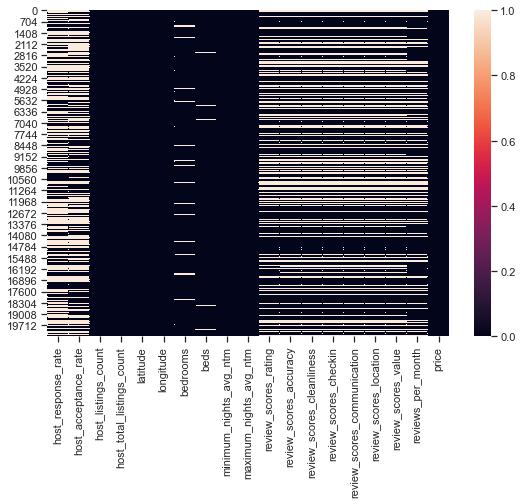

In [319]:
plt.rcParams['figure.figsize'] = (9, 6)
sns.heatmap(train_continuous.isnull())

In [270]:
#Using Multivariate KNN imputer 
from sklearn.impute import KNNImputer

In [271]:
continuous_features = pd.DataFrame(impute_knn.fit_transform(train_continuous), 
                                   columns = train_continuous.columns)

continuous_features.info()

#### Handling Missing Values in Discrete Variables

In [320]:
train_discrete.info()
# no missing values in any discrete variables 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20408 entries, 0 to 20407
Data columns (total 19 columns):
 #   Column                                        Non-Null Count  Dtype
---  ------                                        --------------  -----
 0   accommodates                                  20408 non-null  int64
 1   minimum_nights                                20408 non-null  int64
 2   maximum_nights                                20408 non-null  int64
 3   minimum_minimum_nights                        20408 non-null  int64
 4   maximum_minimum_nights                        20408 non-null  int64
 5   minimum_maximum_nights                        20408 non-null  int64
 6   maximum_maximum_nights                        20408 non-null  int64
 7   availability_30                               20408 non-null  int64
 8   availability_60                               20408 non-null  int64
 9   availability_90                               20408 non-null  int64
 10  availabili

#### Handling Missing Values in categorical Variables

In [323]:
train_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20408 entries, 0 to 20407
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   name                    20408 non-null  object
 1   description             19751 non-null  object
 2   neighborhood_overview   12536 non-null  object
 3   host_name               20408 non-null  object
 4   host_location           20384 non-null  object
 5   host_about              10864 non-null  object
 6   host_response_time      8385 non-null   object
 7   host_is_superhost       20408 non-null  object
 8   host_neighbourhood      12756 non-null  object
 9   host_verifications      20408 non-null  object
 10  host_identity_verified  20408 non-null  object
 11  neighbourhood           12538 non-null  object
 12  neighbourhood_cleansed  20408 non-null  object
 13  property_type           20408 non-null  object
 14  room_type               20408 non-null  object
 15  ba

In [326]:
#dropping variables that are unnecessary and does not impact the Price of an Airbnb listing
train_categorical.drop(['host_name', 'host_about', 'neighborhood_overview','host_response_time'], 
                       axis =1, inplace = True)

#the values of these the dropped variables can be found in neighbourhood_cleansed column
train_categorical.drop(['host_neighbourhood', 'neighbourhood'], axis =1, inplace = True)

In [327]:
train_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20408 entries, 0 to 20407
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   name                    20408 non-null  object
 1   description             19751 non-null  object
 2   host_location           20384 non-null  object
 3   host_is_superhost       20408 non-null  object
 4   host_verifications      20408 non-null  object
 5   host_identity_verified  20408 non-null  object
 6   neighbourhood_cleansed  20408 non-null  object
 7   property_type           20408 non-null  object
 8   room_type               20408 non-null  object
 9   bathrooms_text          20393 non-null  object
 10  amenities               20408 non-null  object
 11  has_availability        20408 non-null  object
 12  instant_bookable        20408 non-null  object
dtypes: object(13)
memory usage: 2.0+ MB


In [328]:
train_categorical['description']=train_categorical['description'].fillna('None')

In [329]:
train_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20408 entries, 0 to 20407
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   name                    20408 non-null  object
 1   description             20408 non-null  object
 2   host_location           20384 non-null  object
 3   host_is_superhost       20408 non-null  object
 4   host_verifications      20408 non-null  object
 5   host_identity_verified  20408 non-null  object
 6   neighbourhood_cleansed  20408 non-null  object
 7   property_type           20408 non-null  object
 8   room_type               20408 non-null  object
 9   bathrooms_text          20393 non-null  object
 10  amenities               20408 non-null  object
 11  has_availability        20408 non-null  object
 12  instant_bookable        20408 non-null  object
dtypes: object(13)
memory usage: 2.0+ MB


In [331]:
train_datetime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20408 entries, 0 to 20407
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   host_since    20408 non-null  datetime64[ns]
 1   first_review  14524 non-null  datetime64[ns]
 2   last_review   14524 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 478.4 KB


In [335]:
#droppign last_review and first_review because of large missing values, host_since is dropped because its values are
#added to host_days
train_datetime.drop(['last_review','first_review','host_since'],axis =1, inplace = True)

KeyError: "['last_review' 'first_review'] not found in axis"

In [333]:
#concatinating all the columns after adding missing values, some values will be imputed for caregorical variables
#during feature engineering phase 
df= pd.concat([continuous_features, train_discrete, train_categorical, train_datetime], axis =1)
df.head()

,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,bedrooms,beds,minimum_nights_avg_ntm,maximum_nights_avg_ntm,...,host_verifications,host_identity_verified,neighbourhood_cleansed,property_type,room_type,bathrooms_text,amenities,has_availability,instant_bookable,host_since
0,1.000,0.600,3.0,3.0,-33.88600,151.22138,1.0,1.0,3.0,3.0,...,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,Sydney,Private room in house,Private room,1 shared bath,"[""Washer"", ""Iron"", ""Hot water"", ""Essentials"", ...",t,t,2015-08-06
1,0.800,0.488,1.0,1.0,-33.89147,151.17989,3.0,3.0,5.0,8.0,...,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,Sydney,Entire house,Entire home/apt,3.5 baths,"[""Patio or balcony"", ""Garden or backyard"", ""Lo...",t,t,2010-12-08
2,1.000,0.900,1.0,1.0,-33.88238,151.21147,1.0,1.0,2.0,1125.0,...,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,Sydney,Entire apartment,Entire home/apt,1 bath,"[""Washer"", ""Long term stays allowed"", ""Microwa...",t,t,2016-09-17
3,0.934,0.970,1.0,1.0,-33.81528,151.00074,1.0,1.0,365.0,1125.0,...,"['email', 'phone', 'reviews', 'offline_governm...",t,Parramatta,Private room in apartment,Private room,1 private bath,"[""Washer"", ""Iron"", ""Long term stays allowed"", ...",t,t,2017-10-27
4,0.800,0.584,0.0,0.0,-33.88649,151.13558,2.0,2.0,3.0,1125.0,...,"['email', 'phone', 'work_email']",f,Ashfield,Entire apartment,Entire home/apt,1 bath,"[""Patio or balcony"", ""Bed linens"", ""Shampoo"", ...",t,t,2019-07-24


In [334]:
df.isnull().sum().sort_values(ascending=False)

host_location                                   24
bathrooms_text                                  15
host_response_rate                               0
name                                             0
availability_90                                  0
availability_365                                 0
number_of_reviews                                0
number_of_reviews_ltm                            0
number_of_reviews_l30d                           0
calculated_host_listings_count                   0
calculated_host_listings_count_entire_homes      0
calculated_host_listings_count_private_rooms     0
calculated_host_listings_count_shared_rooms      0
host_days                                        0
description                                      0
host_acceptance_rate                             0
host_is_superhost                                0
host_verifications                               0
host_identity_verified                           0
neighbourhood_cleansed         

# Feature Engineering

### Encoding Categorical Variables 

In [195]:
df.select_dtypes(include='object').head()

,name,description,host_location,host_response_time,host_is_superhost,host_verifications,host_identity_verified,neighbourhood_cleansed,property_type,room_type,bathrooms_text,amenities,has_availability,instant_bookable
0,Sunny huge private room in Paddington,None,"Sydney, New South Wales, Australia",None,f,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,Sydney,Private room in house,Private room,1 shared bath,"[""Washer"", ""Iron"", ""Hot water"", ""Essentials"", ...",t,t
1,Gorgeous large 3 bedroom terrace house,Our house is perfect for families or small gro...,"New South Wales, Australia",None,f,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,Sydney,Entire house,Entire home/apt,3.5 baths,"[""Patio or balcony"", ""Garden or backyard"", ""Lo...",t,t
2,1 BR Apt with great small terrace in Surry Hills,"Lovely 2 storey apartment in Surry Hills, one ...","Turin, Piedmont, Italy",None,f,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,Sydney,Entire apartment,Entire home/apt,1 bath,"[""Washer"", ""Long term stays allowed"", ""Microwa...",t,t
3,Modern Apartment Close to Everything,Fantastic brand new Apartment with Panoramic v...,"Parramatta, New South Wales, Australia",None,f,"['email', 'phone', 'reviews', 'offline_governm...",t,Parramatta,Private room in apartment,Private room,1 private bath,"[""Washer"", ""Iron"", ""Long term stays allowed"", ...",t,t
4,Charming parkside apartment in quiet area,How many holiday rentals allow you to walk out...,"Sydney, New South Wales, Australia",None,f,"['email', 'phone', 'work_email']",f,Ashfield,Entire apartment,Entire home/apt,1 bath,"[""Patio or balcony"", ""Bed linens"", ""Shampoo"", ...",t,t


In [196]:
df['has_availability'].value_counts()

t    20389
f       19
Name: has_availability, dtype: int64

In [197]:
#dummy variables for Binary features
df = pd.concat([df, pd.get_dummies(df['has_availability'],prefix='has_availability',drop_first=True),
                pd.get_dummies(df['host_is_superhost'],prefix='host_is_superhost',drop_first=True),
                pd.get_dummies(df['instant_bookable'],prefix='has_availability',drop_first=True),
                pd.get_dummies(df['host_identity_verified'],prefix='has_availability',drop_first=True),
                pd.get_dummies(df['room_type'],drop_first=True)], axis =1)

df_test = pd.concat([df_test, pd.get_dummies(df_test['has_availability'],prefix='has_availability',drop_first=True),
                pd.get_dummies(df_test['host_is_superhost'],prefix='host_is_superhost',drop_first=True),
                pd.get_dummies(df_test['instant_bookable'],prefix='has_availability',drop_first=True),
                pd.get_dummies(df_test['host_identity_verified'],prefix='has_availability',drop_first=True),
                pd.get_dummies(df_test['room_type'],drop_first=True)], axis =1)



In [198]:
df.drop(['has_availability', 'host_is_superhost', 'instant_bookable', 'host_identity_verified', 'room_type'], 
        axis = 1, inplace = True)

df_test.drop(['has_availability', 'host_is_superhost', 'instant_bookable', 'host_identity_verified', 'room_type'], 
        axis = 1, inplace = True)


In [199]:
# following columns have very high cardinality
df.drop(['name', 'description','host_location'], axis =1, inplace = True)

df_test.drop(['name', 'description','host_location'], axis =1, inplace = True)


In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20408 entries, 0 to 20407
Data columns (total 54 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   host_response_rate                            20408 non-null  float64       
 1   host_acceptance_rate                          20408 non-null  float64       
 2   host_listings_count                           20408 non-null  float64       
 3   host_total_listings_count                     20408 non-null  float64       
 4   latitude                                      20408 non-null  float64       
 5   longitude                                     20408 non-null  float64       
 6   bedrooms                                      20408 non-null  float64       
 7   beds                                          20408 non-null  float64       
 8   minimum_nights_avg_ntm                        20408 non-null  floa

In [201]:
df.drop(df.columns[47], axis=1, inplace=True)
df.drop(df.columns[49], axis=1, inplace=True)

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20408 entries, 0 to 20407
Data columns (total 50 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   host_response_rate                            20408 non-null  float64       
 1   host_acceptance_rate                          20408 non-null  float64       
 2   host_listings_count                           20408 non-null  float64       
 3   host_total_listings_count                     20408 non-null  float64       
 4   latitude                                      20408 non-null  float64       
 5   longitude                                     20408 non-null  float64       
 6   bedrooms                                      20408 non-null  float64       
 7   beds                                          20408 non-null  float64       
 8   minimum_nights_avg_ntm                        20408 non-null  floa

In [203]:
#High cardinality features
sparse_cats = df.property_type.value_counts().head(4).index.tolist() + ['other_property_type']
df['property_type'] = pd.Categorical(df['property_type'], categories=sparse_cats).fillna('other_property_type')


    

In [204]:
sparse_cats_test = df_test.property_type.value_counts().head(4).index.tolist() + ['other_property_type']
df_test['property_type'] = pd.Categorical(df_test['property_type'], categories=sparse_cats_test).fillna('other_property_type')

In [205]:
df['property_type'].value_counts()

Entire apartment             8867
Entire house                 3337
other_property_type          3273
Private room in apartment    3127
Private room in house        1804
Name: property_type, dtype: int64

In [206]:
df_test['property_type'].value_counts()

Entire apartment             3772
Entire house                 1447
other_property_type          1420
Private room in apartment    1379
Private room in house         729
Name: property_type, dtype: int64

In [207]:
df = pd.concat([df, pd.get_dummies(df['property_type'],drop_first=True)], axis =1)

df_test = pd.concat([df_test, pd.get_dummies(df_test['property_type'],drop_first=True)], axis =1)


In [208]:
df.drop(['property_type'], axis =1, inplace = True)

df_test.drop(['property_type'], axis =1, inplace = True)


In [209]:
df = df.join(pd.get_dummies(df['host_response_time'],drop_first=True))

df_test = df_test.join(pd.get_dummies(df_test['host_response_time'],drop_first=True))

In [210]:
df_test.shape

(8747, 60)

In [41]:
!mamba install -c conda-forge category_encoders -y


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.4.2) supported by @QuantStack

        GitHub:  https://github.com/QuantStack/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████

pkgs/main/noarch         [>                   ] (--:--) No change
pkgs/main/noarch         [====================]

In [211]:
from category_encoders.glmm import GLMMEncoder 

predictor = ['neighbourhood_cleansed']
y_train=df['price']   
encoder = GLMMEncoder().fit(df[predictor], y_train) 
df['neighbourhood_cleansedGL'] = encoder.transform(df[predictor])
df_test['neighbourhood_cleansedGL'] = encoder.transform(df_test[predictor])




In [212]:
df.drop(['neighbourhood_cleansed', 'host_verifications'], axis =1, inplace = True)
df_test.drop(['neighbourhood_cleansed', 'host_verifications'], axis =1, inplace = True)

In [213]:
df['bathrooms_text'] = df['bathrooms_text'].astype(str).apply(lambda x:x.split()[0])
df.loc[~df['bathrooms_text'].str.replace('.','').str.isdigit(),['bathrooms_text']] = 0.5
df['bathrooms_text']=df['bathrooms_text'].astype(float)

df_test['bathrooms_text'] = df_test['bathrooms_text'].astype(str).apply(lambda x:x.split()[0])
df_test.loc[~df_test['bathrooms_text'].str.replace('.','').str.isdigit(),['bathrooms_text']] = 0.5
df_test['bathrooms_text']=df_test['bathrooms_text'].astype(float)


In [214]:
df['first_review'].unique()

array([                          'NaT', '2018-07-13T00:00:00.000000000',
       '2018-01-04T00:00:00.000000000', ...,
       '2013-07-09T00:00:00.000000000', '2013-08-13T00:00:00.000000000',
       '2014-06-12T00:00:00.000000000'], dtype='datetime64[ns]')

In [215]:
df.drop(['first_review', 'last_review', 'amenities', 'host_response_time', 'host_since' ], axis =1, inplace = True)

df_test.drop(['first_review', 'last_review', 'amenities', 'host_response_time', 'host_since' ], axis =1, inplace = True)

In [216]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20408 entries, 0 to 20407
Data columns (total 51 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   host_response_rate                            20408 non-null  float64
 1   host_acceptance_rate                          20408 non-null  float64
 2   host_listings_count                           20408 non-null  float64
 3   host_total_listings_count                     20408 non-null  float64
 4   latitude                                      20408 non-null  float64
 5   longitude                                     20408 non-null  float64
 6   bedrooms                                      20408 non-null  float64
 7   beds                                          20408 non-null  float64
 8   minimum_nights_avg_ntm                        20408 non-null  float64
 9   maximum_nights_avg_ntm                        20408 non-null 

## Simple Linear Regression Model

### Feature selection for Simple Linear regression model

In [217]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm

In [218]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

In [219]:
X = df.drop(['price'], axis =1)
y = np.log(df['price'])

In [220]:
X_train, X_rem, y_train, y_rem = train_test_split(X,y, test_size = 0.33, random_state = 50)

In [221]:
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

## Ordinary Least Squares (OLS)

In [225]:
ols = LinearRegression()
ols.fit(X_train, y_train)
#ols.score(X_train, y_train)
y_pred=ols.predict(X_valid)

mean_squared_error(y_valid, y_pred)
r2_score(y_valid, y_pred)
#r2_score(y_val, y_pred)

0.6519953269529495

In [226]:
y_pred_test = ols.predict(X_test)

mean_squared_error(y_test, y_pred_test)
r2_score(y_test, y_pred_test)

0.6485249742158876

In [227]:
ols.score(X_test, y_test)

0.6485249742158876

## OLS with RFE with n=10

In [228]:
from sklearn.feature_selection import RFE
rfe = RFE(estimator=LinearRegression(), n_features_to_select=10)
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=10)

In [229]:
rfe.support_ #selected features

array([ True, False, False, False, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True, False,
        True,  True, False, False, False])

In [230]:
X_train.loc[:,rfe.support_]

,host_response_rate,longitude,bedrooms,Hotel room,Shared room,Entire house,Private room in apartment,Private room in house,a few days or more,within a day
20269,0.726,151.24579,1.0,0,0,0,0,0,0,0
3238,1.000,150.70732,2.0,0,0,0,0,0,0,0
8250,1.000,151.25763,2.0,0,0,0,0,0,0,1
16069,1.000,151.23689,3.0,0,0,1,0,0,0,0
4901,0.528,151.22646,1.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
14565,1.000,151.05096,1.0,0,0,0,0,0,0,0
15649,0.726,151.27062,1.0,0,0,0,1,0,0,0
10123,0.800,151.24366,1.0,0,0,0,1,0,0,0
5600,1.000,151.28173,1.0,0,0,0,0,0,0,0


In [231]:
m = LinearRegression()
m.fit(rfe.transform(X_train), y_train)

y_pred_m = m.predict(rfe.transform(X_valid))

#mean_squared_error(y_val, y_pred_m)
#r2_score(y_val, y_pred_m)

y_pred_m_test = m.predict(rfe.transform(X_test))
#r2_score(y_test, y_pred_m_test)
mean_squared_error(y_test, y_pred_m_test)
#forest.score(rfe.transform(X_test_std), y_test)

0.2400516826194627

## OLS with RFECV

In [232]:
rfecv = RFECV(
    estimator=LinearRegression(),
    min_features_to_select=5,
    step=5,
    n_jobs=-1,
    scoring= 'neg_root_mean_squared_error' ,
    cv=5,
)

_ = rfecv.fit(X_train, y_train)

In [233]:
len(X_train.columns[rfecv.support_])

50

In [234]:
X_train.loc[:,rfecv.support_]

,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,bedrooms,beds,minimum_nights_avg_ntm,maximum_nights_avg_ntm,...,Shared room,Entire house,Private room in apartment,Private room in house,other_property_type,a few days or more,within a day,within a few hours,within an hour,neighbourhood_cleansedGL
20269,0.726,0.400,1.0,1.0,-33.97899,151.24579,1.0,1.0,7.0,28.0,...,0,0,0,0,0,0,0,0,0,7.525969
3238,1.000,0.910,4.0,4.0,-33.75937,150.70732,2.0,3.0,1.0,1125.0,...,0,0,0,0,0,0,0,0,1,-25.647210
8250,1.000,0.900,1.0,1.0,-33.93058,151.25763,2.0,2.0,7.0,1125.0,...,0,0,0,0,0,0,1,0,0,7.525969
16069,1.000,1.000,2.0,2.0,-33.82249,151.23689,3.0,3.0,21.0,1125.0,...,0,1,0,0,0,0,0,1,0,233.301990
4901,0.528,0.300,1.0,1.0,-33.83152,151.22646,1.0,1.0,21.0,40.0,...,0,0,0,0,0,0,0,0,0,2.496166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14565,1.000,1.000,1.0,1.0,-33.94510,151.05096,1.0,1.0,1.0,1125.0,...,0,0,0,0,0,0,0,0,1,-64.881916
15649,0.726,0.900,0.0,0.0,-33.89507,151.27062,1.0,1.0,7.0,1125.0,...,0,0,1,0,0,0,0,0,0,51.283814
10123,0.800,0.750,1.0,1.0,-33.91968,151.24366,1.0,1.0,2.0,1125.0,...,0,0,1,0,0,0,0,0,0,7.525969
5600,1.000,0.436,1.0,1.0,-33.78026,151.28173,1.0,1.0,4.0,8.0,...,0,0,0,0,0,0,0,0,0,95.995650


In [235]:
a = LinearRegression()
a.fit(rfecv.transform(X_train), y_train)

y_pred_a = a.predict(rfecv.transform(X_valid))

#mean_squared_error(y_val, y_pred_m)
#r2_score(y_val, y_pred_m)

y_pred_a_test = a.predict(rfecv.transform(X_test))
#r2_score(y_test, y_pred_m_test)
mean_squared_error(y_test, y_pred_a_test)

#print("Trainig R-sqaured:", lr.score(X_train, y_train))
#print("Testing R-squared:",lr.score(X_test, y_test))


0.2043734432627062

In [236]:
data = [['Ordinary Least Squares', mean_squared_error(y_test, y_pred_test), r2_score(y_test, y_pred_test)], 
        ['Recursive Feature Elimination', mean_squared_error(y_test, y_pred_m_test),r2_score(y_test, y_pred_m_test)], 
        ['Recursive Feature Elimination with Cross Validation', mean_squared_error(y_test, y_pred_a_test),r2_score(y_test, y_pred_a_test)]]

df_results = pd.DataFrame(data, columns = ['Method', 'Mean Squared Error', 'r2 score'])

df_results

,Method,Mean Squared Error,r2 score
0,Ordinary Least Squares,0.204373,0.648525
1,Recursive Feature Elimination,0.240052,0.587167
2,Recursive Feature Elimination with Cross Valid...,0.204373,0.648525


## Lasso Regression

In [237]:
from sklearn import linear_model
from sklearn.linear_model import LassoCV

In [238]:
lasso = LassoCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,
                                0.3, 0.6],max_iter=50000, cv=10)
lasso.fit(X_train,y_train)
y_pred_val=lasso.predict(X_valid)
# The coefficients
#print('intercept: \n',lasso.intercept_)
#print('Coefficients: \n', lasso.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_valid, y_pred_val))
#print('Mean absolute error:%.2f'
      #% mean_absolute_error(y_vali, y_pred_val))     
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_valid, y_pred_val))

Mean squared error: 0.20
Coefficient of determination: 0.65


In [239]:
y_pred_test_lasso=lasso.predict(X_test)
r2_score(y_test, y_pred_test_lasso)
#mean_squared_error(y_test, y_pred_test_lasso)

0.6480727732659413

In [240]:
data_lasso = [['Ordinary Least Squares', mean_squared_error(y_test, y_pred_test), r2_score(y_test, y_pred_test)], 
        ['Recursive Feature Elimination', mean_squared_error(y_test, y_pred_m_test),r2_score(y_test, y_pred_m_test)], 
        ['Recursive Feature Elimination with Cross Validation', mean_squared_error(y_test, y_pred_a_test),r2_score(y_test, y_pred_a_test)],
        ['Lasso Regression', mean_squared_error(y_test, y_pred_test_lasso),r2_score(y_test, y_pred_test_lasso)]]

df_results_lasso = pd.DataFrame(data_lasso, columns = ['Method', 'Mean Squared Error', 'r2 score'])

df_results_lasso

,Method,Mean Squared Error,r2 score
0,Ordinary Least Squares,0.204373,0.648525
1,Recursive Feature Elimination,0.240052,0.587167
2,Recursive Feature Elimination with Cross Valid...,0.204373,0.648525
3,Lasso Regression,0.204636,0.648073


## Tree Based Model - Decision Tree with Grid Search CV

In [241]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV 

# find hyperparameter
model = DecisionTreeRegressor(min_samples_leaf=5)
path = model.cost_complexity_pruning_path(X_train, y_train)
alphas = path.ccp_alphas

search_space = {
    'ccp_alpha': alphas,
}

tree =  GridSearchCV (model, search_space, cv = 5)

In [242]:
# train the model 
tree.fit(X_train, y_train)

y_pred_tree=tree.predict(X_valid)
print('Mean squared error: %.2f'
      % mean_squared_error(y_valid, y_pred_tree))
print('Mean absolute error:%.2f'
      % mean_absolute_error(y_valid, y_pred_tree))

Mean squared error: 0.21
Mean absolute error:0.34


In [243]:
y_pred_tree_test = tree.predict(X_test)
r2_score(y_test, y_pred_tree_test)
mean_squared_error(y_test, y_pred_tree_test)

0.21058883607365358

## Tree Based Model - Decision Tree With Randomized Search CV

In [244]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV


model = DecisionTreeRegressor(min_samples_leaf=5)
path = model.cost_complexity_pruning_path(X_train, y_train)
alphas = path.ccp_alphas

search_space = {
    'ccp_alpha': alphas,
}

#hyperparameter optimization
tree_search = RandomizedSearchCV(model, search_space, cv = 5)
tree_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(min_samples_leaf=5),
                   param_distributions={'ccp_alpha': array([0.00000000e+00, 3.49136583e-07, 3.73398730e-07, ...,
       2.09395234e-02, 5.23343810e-02, 2.12457035e-01])})

In [245]:
# train the model 
tree_search.fit(X_train, y_train)

y_pred_tree_rs=tree_search.predict(X_valid)
print('Mean squared error: %.2f'
      % mean_squared_error(y_valid, y_pred_tree_rs))
print('Mean absolute error:%.2f'
      % mean_absolute_error(y_valid, y_pred_tree_rs))

Mean squared error: 0.22
Mean absolute error:0.35


In [246]:
y_pred_tree_test_rs = tree_search.predict(X_test)
r2_score(y_test, y_pred_tree_test_rs)
mean_squared_error(y_test, y_pred_tree_test_rs)

0.2186545506223349

In [247]:
data_tree = [['Ordinary Least Squares', mean_squared_error(y_test, y_pred_test), r2_score(y_test, y_pred_test)], 
        ['Recursive Feature Elimination', mean_squared_error(y_test, y_pred_m_test),r2_score(y_test, y_pred_m_test)], 
        ['Recursive Feature Elimination with Cross Validation', mean_squared_error(y_test, y_pred_a_test),r2_score(y_test, y_pred_a_test)],
        ['Lasso Regression', mean_squared_error(y_test, y_pred_test_lasso),r2_score(y_test, y_pred_test_lasso)],
         ['Decision tree GS', mean_squared_error(y_test, y_pred_tree_test),r2_score(y_test, y_pred_tree_test)],
            ['Decision tree RS', mean_squared_error(y_test, y_pred_tree_test_rs),r2_score(y_test, y_pred_tree_test_rs)]]

df_results_tree = pd.DataFrame(data_tree, columns = ['Method', 'Mean Squared Error', 'r2 score'])

df_results_tree

,Method,Mean Squared Error,r2 score
0,Ordinary Least Squares,0.204373,0.648525
1,Recursive Feature Elimination,0.240052,0.587167
2,Recursive Feature Elimination with Cross Valid...,0.204373,0.648525
3,Lasso Regression,0.204636,0.648073
4,Decision tree GS,0.210589,0.637836
5,Decision tree RS,0.218655,0.623965


## Random Forest

In [248]:
from sklearn.ensemble import RandomForestRegressor

In [249]:
rf = RandomForestRegressor(n_estimators = 1000, min_samples_leaf = 3, max_features = 9)
rf.fit (X_train, y_train)

RandomForestRegressor(max_features=9, min_samples_leaf=3, n_estimators=1000)

In [250]:
y_test_rf = rf.predict(X_test)
r2_score(y_test, y_test_rf)
#mean_squared_error(y_test, y_test_rf)

0.7184153258592982

## Boosting - Light Gradient Boosting Machine

In [105]:
!mamba install -c conda-forge lightgbm -y


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██�� ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.4.2) supported by @QuantStack

        GitHub:  https://github.com/QuantStack/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████

pkgs/r/osx-64            [>                   ] (--:--) No change
pkgs/r/osx-64            [====================

In [222]:
import lightgbm as lgb

lgbm = lgb.LGBMRegressor(objective='regression', boosting_type = 'gbdt', 
                         n_estimators = 1974, learning_rate = 0.01,  
                         num_leaves = 24,
                         lambda_l1 = 0.0, lambda_l2 = 0.0,
                         bagging_fraction = 0.74, bagging_freq = 1, 
                         feature_fraction = 1.0, min_data_in_leaf = 1)

lgbm = lgbm.fit(X_train, y_train)

In [224]:
y_test_lgb = lgbm.predict(X_test)
r2_score(y_test, y_test_lgb)
#mean_squared_error(y_test, y_test_lgb)

0.14692254805809543

In [253]:
data_boost = [['Ordinary Least Squares', mean_squared_error(y_test, y_pred_test), r2_score(y_test, y_pred_test)], 
        ['Recursive Feature Elimination', mean_squared_error(y_test, y_pred_m_test),r2_score(y_test, y_pred_m_test)], 
        ['Recursive Feature Elimination with Cross Validation', mean_squared_error(y_test, y_pred_a_test),r2_score(y_test, y_pred_a_test)],
        ['Lasso Regression', mean_squared_error(y_test, y_pred_test_lasso),r2_score(y_test, y_pred_test_lasso)],
         ['Decision tree GS', mean_squared_error(y_test, y_pred_tree_test),r2_score(y_test, y_pred_tree_test)],
            ['Decision tree RS', mean_squared_error(y_test, y_pred_tree_test_rs),r2_score(y_test, y_pred_tree_test_rs)],
             ['Random Forest', mean_squared_error(y_test, y_test_rf),r2_score(y_test, y_test_rf)],
              ['LGB boosting', mean_squared_error(y_test, y_test_lgb),r2_score(y_test, y_test_lgb)]]

df_results_boost = pd.DataFrame(data_boost, columns = ['Method', 'Mean Squared Error', 'r2 score'])

df_results_boost

,Method,Mean Squared Error,r2 score
0,Ordinary Least Squares,0.204373,0.648525
1,Recursive Feature Elimination,0.240052,0.587167
2,Recursive Feature Elimination with Cross Valid...,0.204373,0.648525
3,Lasso Regression,0.204636,0.648073
4,Decision tree GS,0.210589,0.637836
5,Decision tree RS,0.218655,0.623965
6,Random Forest,0.163734,0.718415
7,LGB boosting,0.146923,0.747327
